# 0. Install and Import Dependencies

In [1]:
import os
import cv2
import torch
import numpy as np
from typing import List,Tuple
import matplotlib.pyplot as plt
import imageio


In [2]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# 1. Build Data Loading Functions

In [3]:
def load_video(path: str) -> torch.Tensor:
    cap = cv2.VideoCapture(path)
    frames = []
    
    # Read all frames from the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        # Convert to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame[190:236, 80:220]  # Cropping the frame
        frames.append(frame)
    
    cap.release()
    
    # Convert frames to a Torch tensor and normalize
    frames = torch.tensor(frames, dtype=torch.float32)
    mean = frames.mean()
    std = frames.std()
    frames = (frames - mean) / std  # Standardize frames
    return frames


In [4]:
# Define the vocabulary
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab_size = len(vocab)

# Create mappings: character to index and index to character
char_to_num = {char: idx for idx, char in enumerate(vocab)}
num_to_char = {idx: char for idx, char in enumerate(vocab)}

print(f"The vocabulary is: {vocab} (size = {vocab_size})")

# Example usage: converting characters to numbers
example_chars = ['n', 'i', 'c', 'k']
example_nums = [char_to_num[char] for char in example_chars]
print("Character to number:", example_nums)

# Example usage: converting numbers back to characters
example_indices = [14, 9, 3, 11]
example_chars_back = [num_to_char[idx] for idx in example_indices]
print("Number to character:", example_chars_back)


The vocabulary is: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 39)
Character to number: [13, 8, 2, 10]
Number to character: ['o', 'j', 'd', 'l']


In [5]:
def load_alignments(path: str) -> List[int]:
    with open(path, 'r') as f:
        lines = f.readlines()
    
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])  # Extend the list with space and the word
    
    # Convert tokens to numbers using our char_to_num mapping
    alignment_numbers = [char_to_num[char] for char in ''.join(tokens).strip()]
    return alignment_numbers

def load_data(path: str):
    # Decode the path and get the file name
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    # Load video frames and alignments
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


C:\Users\preet\AppData\Local\Temp\ipykernel_19144\3419181741.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  frames = torch.tensor(frames, dtype=torch.float32)


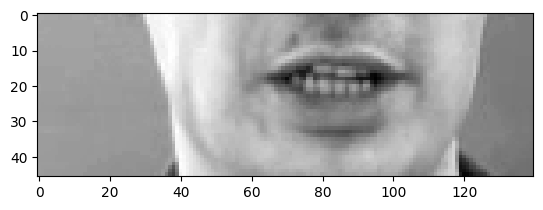

Alignments (numeric): [1, 8, 13, 38, 1, 11, 20, 4, 38, 0, 19, 38, 11, 38, 18, 8, 23, 38, 13, 14, 22]
Alignments (characters): bin blue at l six now


In [6]:
import matplotlib.pyplot as plt

# Test path for visualization
test_path = '.\\data\\s1\\bbal6n.mpg'

# Load frames and alignments using the load_data function
frames, alignments = load_data(test_path)

# Visualize a specific frame (e.g., the 40th frame)
plt.imshow(frames[40], cmap='gray')
plt.show()

# Print alignments
print("Alignments (numeric):", alignments)

# Convert alignments from numbers to characters
alignment_chars = ''.join([num_to_char[num] for num in alignments])
print("Alignments (characters):", alignment_chars)


# 2. Create Data Pipeline

In [7]:
from torch.utils.data import Dataset, DataLoader
import glob
import random

# Custom Dataset class for PyTorch
class LipReadingDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        frames, alignments = load_data(path)
        return torch.tensor(frames, dtype=torch.float32), torch.tensor(alignments, dtype=torch.long)

# List all video files
file_paths = glob.glob('.\\data\\s1\\*.mpg')
random.shuffle(file_paths)

# Split into training and testing
train_paths = file_paths[:450]
test_paths = file_paths[450:]

# Create datasets
train_dataset = LipReadingDataset(train_paths)
test_dataset = LipReadingDataset(test_paths)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,pin_memory=True)

# 3. Design the Deep Neural Network

In [8]:
import torch
import torch.nn as nn

class LipReadingModel(nn.Module):
    def __init__(self, vocab_size):
        super(LipReadingModel, self).__init__()
        # 3D Convolutional layers
        self.conv3d_1 = nn.Conv3d(1, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.relu = nn.ReLU()
        self.maxpool3d_1 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv3d_2 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.maxpool3d_2 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv3d_3 = nn.Conv3d(256, 75, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.maxpool3d_3 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        # Bi-directional LSTM layers
        self.lstm_1 = nn.LSTM(6375, 128, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout_1 = nn.Dropout(0.5)

        self.lstm_2 = nn.LSTM(256, 128, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout_2 = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(256, vocab_size + 1)  # +1 for CTC blank token

    def forward(self, x):
        # x shape: (batch_size, channels, depth, height, width)
        x = self.relu(self.conv3d_1(x))
        x = self.maxpool3d_1(x)

        x = self.relu(self.conv3d_2(x))
        x = self.maxpool3d_2(x)

        x = self.relu(self.conv3d_3(x))
        x = self.maxpool3d_3(x)

        # Flatten the features for LSTM input
        batch_size, channels, depth, height, width = x.size()
        x = x.view(batch_size, depth, channels * height * width)  # (batch_size, depth, features)

        # BiLSTM layers
        x, _ = self.lstm_1(x)
        x = self.dropout_1(x)

        x, _ = self.lstm_2(x)
        x = self.dropout_2(x)

        # Fully connected layer
        x = self.fc(x)
        return x

# Example usage
vocab_size = len(vocab)
model = LipReadingModel(vocab_size)
model = model.to(device)  # Move the model to GPU if available
print(model)


LipReadingModel(
  (conv3d_1): Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu): ReLU()
  (maxpool3d_1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3d_2): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (maxpool3d_2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3d_3): Conv3d(256, 75, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (maxpool3d_3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (lstm_1): LSTM(6375, 128, batch_first=True, bidirectional=True)
  (dropout_1): Dropout(p=0.5, inplace=False)
  (lstm_2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=40, bias=True)
)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CTC Loss function as in the original notebook
# 'blank=0' for the CTC blank token, 'reduction' is set to 'mean' as typically done for loss averaging.
ctc_loss_fn = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

# Define the optimizer
# Assuming 'model' is already defined elsewhere in your code
torch.manual_seed(42)  # For reproducibility
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Optional: Learning Rate Scheduler
# Exponential decay of the learning rate
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  # gamma is the decay factor

# Usage in your training loop
def compute_loss(ctc_output, ctc_targets, input_lengths, target_lengths):
    # Compute the CTC loss, where ctc_output is of shape (T, N, C)
    # ctc_targets is a flattened tensor of target labels for the entire batch
    # input_lengths and target_lengths are 1D tensors indicating the lengths of each input and target respectively
    ctc_loss = ctc_loss_fn(ctc_output, ctc_targets, input_lengths, target_lengths)
    return ctc_loss



# 4. Setup Training Options and Train

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from jiwer import wer  # Import jiwer for WER calculation

# Training loop
num_epochs = 100  # Adjust as needed
model.train()  # Set the model to training mode

with open("validation_results.txt", "w") as log_file:
    for epoch in range(num_epochs):
        try:
            epoch_loss = 0  # Track the total loss for the epoch

            with tqdm(train_loader, unit="batch") as progress_bar:
                progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}")

                for batch in progress_bar:
                    frames, alignments = batch
                    frames = frames[0].to(device)  # Move frames to the device (single video sequence)
                    alignments = alignments[0].to(device)  # Move alignments to the device (single sequence)

                    frames = frames.unsqueeze(0).unsqueeze(1)  # (batch_size=1, channels=1, depth, height, width)
                    input_length = torch.tensor([frames.size(2)], dtype=torch.long).to(device)
                    target_length = torch.tensor([len(alignments)], dtype=torch.long).to(device)

                    optimizer.zero_grad()
                    outputs = model(frames)  # Outputs shape: (batch_size, seq_length, num_classes)
                    outputs = outputs.permute(1, 0, 2)  # (seq_length, batch_size, num_classes)

                    # Compute the CTC loss using the provided compute_loss function
                    loss = compute_loss(outputs, alignments, input_length, target_length)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()
                    progress_bar.set_postfix(loss=loss.item())

            # Learning rate scheduler step (if using)
            scheduler.step()

            avg_epoch_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}")

            # Save the model weights after every epoch (overwrite the same file)
            torch.save(model.state_dict(), "lip_reading_model_weights.pth")
            print(f"Model weights updated and saved.")

            # Validate the model every 5 epochs
            if (epoch + 1) % 5 == 0:
                model.eval()
                val_loss = 0
                all_predictions = []
                all_references = []

                with torch.no_grad():
                    for val_batch in test_loader:
                        val_frames, val_alignments = val_batch
                        val_frames = val_frames[0].to(device)
                        val_alignments = val_alignments[0].to(device)

                        val_frames = val_frames.unsqueeze(0).unsqueeze(1)
                        val_input_length = torch.tensor([val_frames.size(2)], dtype=torch.long).to(device)
                        val_target_length = torch.tensor([len(val_alignments)], dtype=torch.long).to(device)

                        val_outputs = model(val_frames)
                        val_outputs = val_outputs.permute(1, 0, 2)
                        val_loss += compute_loss(val_outputs, val_alignments, val_input_length, val_target_length).item()

                        predicted_indices = torch.argmax(val_outputs, dim=-1).squeeze().tolist()
                        predicted_text = ''.join([num_to_char[i] for i in predicted_indices if i != 0])
                        true_text = ''.join([num_to_char[i] for i in val_alignments.cpu().numpy()])

                        all_predictions.append(predicted_text)
                        all_references.append(true_text)

                        log_file.write(f"Epoch {epoch + 1}\n")
                        log_file.write(f"Prediction: {predicted_text}\n")
                        log_file.write(f"Label: {true_text}\n")
                        log_file.write("\n")

                avg_val_loss = val_loss / len(test_loader)
                print(f"Validation Loss at Epoch {epoch + 1}: {avg_val_loss}")

                wer_value = wer(all_references, all_predictions)
                print(f"Word Error Rate (WER) at Epoch {epoch + 1}: {wer_value}")

                print("\nSample Predictions and Labels:")
                for i in range(min(5, len(all_predictions))):
                    print(f"Prediction: {all_predictions[i]}")
                    print(f"Label: {all_references[i]}\n")

                model.train()

        except Exception as e:
            print(f"Error during epoch {epoch + 1}: {e}")
            break


Epoch 1/100:   0%|          | 0/450 [00:00<?, ?batch/s]C:\Users\preet\AppData\Local\Temp\ipykernel_3312\2377108712.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(frames, dtype=torch.float32), torch.tensor(alignments, dtype=torch.long)
Epoch 1/100:  33%|███▎      | 148/450 [01:01<01:52,  2.69batch/s, loss=1.77] 

# Prediction and Testing


In [10]:
import torch
import cv2
import os

# Load the trained model
def load_model_weights(model, weight_path, device):
    with open(weight_path, 'rb') as f:
        state_dict = torch.load(f, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()  # Set the model to evaluation mode

# Function to preprocess the video
def preprocess_video(video_path, device):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        frame = frame[190:236, 80:220]  # Crop to focus on the mouth region
        frames.append(frame)

    cap.release()

    # Convert frames to a Torch tensor and normalize
    frames = torch.tensor(frames, dtype=torch.float32)  # Shape: (depth, height, width)
    frames = frames.unsqueeze(1)  # Add channel dimension: (depth, 1, height, width)
    
    # Normalize the frames
    mean = frames.mean()
    std = frames.std()
    frames = (frames - mean) / std  # Standardize frames

    # Rearrange dimensions to (batch_size, channels, depth, height, width)
    frames = frames.permute(1, 0, 2, 3).unsqueeze(0).to(device)  # (1, 1, depth, height, width)
    return frames

# Function to extract lip coordinates from a .align file
def extract_lip_coordinates(align_path):
    coordinates = []
    with open(align_path, 'r') as f:
        for line in f:
            values = line.strip().split()
            if len(values) == 1:  # If the line has a single value, it may represent a coordinate
                coordinates.append(float(values[0]))
    return torch.tensor(coordinates, dtype=torch.float32)

# Function to make predictions using the model
def predict(video_path, align_path, model, device):
    # Preprocess the input video
    frames = preprocess_video(video_path, device)
    # Load lip coordinates
    lip_coordinates = extract_lip_coordinates(align_path).to(device)

    # Combine frames and lip coordinates if needed
    # Note: Modify this section based on how your model uses lip coordinates
    inputs = (frames, lip_coordinates.unsqueeze(0))  # Add batch dimension to coordinates

    # Make predictions with no gradient computation
    with torch.no_grad():
        outputs = model(*inputs)  # Forward pass through the model
        outputs = outputs.permute(1, 0, 2)  # Reshape for CTC decoding: (seq_length, batch_size, num_classes)

    # Get the predicted character indices
    predicted_indices = torch.argmax(outputs, dim=-1).squeeze().tolist()

    # Decode the indices into characters
    predicted_text = ''.join([num_to_char[i] for i in predicted_indices if i != 0])
    return predicted_text

# Load the model and set it to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)  # Ensure vocab is defined
model = LipReadingModel(vocab_size=vocab_size)  # Replace with your model class

# Load the pre-trained weights from the pickle file
weight_path = "D:\Python Code\LipCoordNet_coords_loss_0.025581153109669685_wer_0.01746208431890914_cer_0.006488426950253695.pt"
load_model_weights(model, weight_path, device)

# Path to the video and .align file
video_path = "D:\Python Code\data\s1\srbb4n.mpg"
align_path = "D:\Python Code\data\alignments\s1\srbb4n.mpg"

# Make predictions
predicted_text = predict(video_path, align_path, model, device)
print("Predicted Text:", predicted_text)


C:\Users\preet\AppData\Local\Temp\ipykernel_19144\1026220533.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=device)


RuntimeError: Error(s) in loading state_dict for LipReadingModel:
	Missing key(s) in state_dict: "conv3d_1.weight", "conv3d_1.bias", "conv3d_2.weight", "conv3d_2.bias", "conv3d_3.weight", "conv3d_3.bias", "lstm_1.weight_ih_l0", "lstm_1.weight_hh_l0", "lstm_1.bias_ih_l0", "lstm_1.bias_hh_l0", "lstm_1.weight_ih_l0_reverse", "lstm_1.weight_hh_l0_reverse", "lstm_1.bias_ih_l0_reverse", "lstm_1.bias_hh_l0_reverse", "lstm_2.weight_ih_l0", "lstm_2.weight_hh_l0", "lstm_2.bias_ih_l0", "lstm_2.bias_hh_l0", "lstm_2.weight_ih_l0_reverse", "lstm_2.weight_hh_l0_reverse", "lstm_2.bias_ih_l0_reverse", "lstm_2.bias_hh_l0_reverse", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "gru1.weight_ih_l0", "gru1.weight_hh_l0", "gru1.bias_ih_l0", "gru1.bias_hh_l0", "gru1.weight_ih_l0_reverse", "gru1.weight_hh_l0_reverse", "gru1.bias_ih_l0_reverse", "gru1.bias_hh_l0_reverse", "gru2.weight_ih_l0", "gru2.weight_hh_l0", "gru2.bias_ih_l0", "gru2.bias_hh_l0", "gru2.weight_ih_l0_reverse", "gru2.weight_hh_l0_reverse", "gru2.bias_ih_l0_reverse", "gru2.bias_hh_l0_reverse", "FC.weight", "FC.bias", "coord_gru.weight_ih_l0", "coord_gru.weight_hh_l0", "coord_gru.bias_ih_l0", "coord_gru.bias_hh_l0", "coord_gru.weight_ih_l0_reverse", "coord_gru.weight_hh_l0_reverse", "coord_gru.bias_ih_l0_reverse", "coord_gru.bias_hh_l0_reverse". 